# Deep Learning 

### Learning type is multi class image classification, framework used is tensorflow and architecture is VGG16

* Importing all the required libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import vgg16 as vgg
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam,SGD
from matplotlib import pyplot
from collections import defaultdict
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

# Data Acquisition 

In [2]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


## Data Exploration

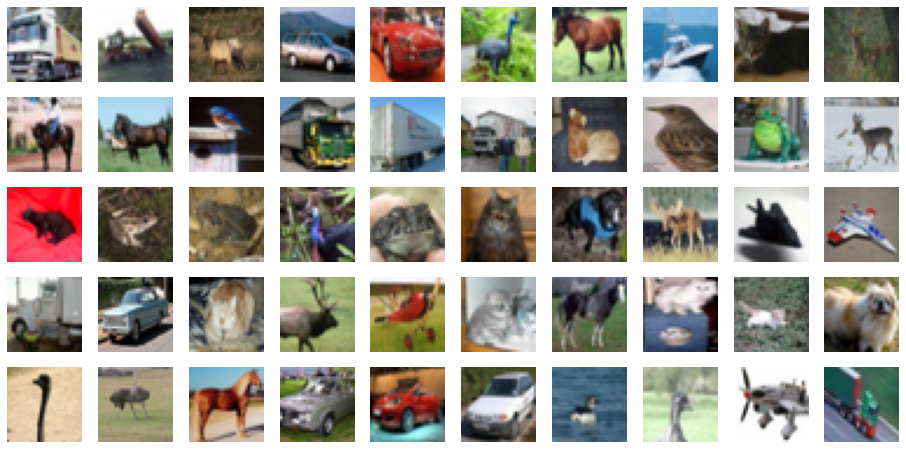

In [3]:
# plot first few images

fig=pyplot.figure(figsize=(16, 8))
columns = 10
rows = 5
for i in range(1, columns*rows +1):
    img = X_train[i]
    fig.add_subplot(rows, columns, i)
    pyplot.axis('off')
    pyplot.imshow(img)
pyplot.show()

# Data Pre-processing

In [4]:
#Data preprocessing 
X_train=X_train/255.0
X_test=X_test/255.0

# one hot encoding on target variables
NUM_CLASSES = 10
Y_train = to_categorical(y_train, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)

## Splitting training data into training and validation

In [5]:
# Data splitting into training and validation sets into 35,000 training and 15,000 Validation 
X_train_new, X_val, Y_train_new, Y_val = train_test_split(X_train, 
                                                  Y_train, 
                                                  test_size=0.30, 
                                                  stratify=np.array(Y_train), 
                                                  random_state=42)
print("New Training data")
print(X_train_new.shape)
print(Y_train_new.shape)

print("Validation data")
print(X_val.shape)
print(Y_val.shape)

New Training data
(35000, 32, 32, 3)
(35000, 10)
Validation data
(15000, 32, 32, 3)
(15000, 10)


# Model Preparation 

In [6]:
# we are considering VGG16 Model pretrained on the Imagenet dataset
base_model = vgg.VGG16(weights='imagenet', #pre-trained model on imagenet
                       include_top=False, #not include the top layer
                       input_shape=(32, 32, 3)) #input size is 32*32*3

In [7]:
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [8]:
# Freeze four convolution blocks
for layer in base_model.layers[:15]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [9]:
x = base_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x) # Softmax for multiclass
model = Model(base_model.input, pred)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [11]:
#ReduceLROnPlateau - It reduces the learning rate by a factor as if there is no improvement seen for patience(which is no of epochs) 
#ModelCheckPoint - Callback to save the Keras model or model weights at some frequency.
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint = ModelCheckpoint('vgg16_finetune.hdf5', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [13]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

* for softmax currentlayer*previouslayer+currentlayer =2570
* relu=131328
* dense1=262656
* dense2= 131328
* dense 3(softmax)= 2570
* from conv layers = 2359808*3 = 7079424
* Total = 7475978


# Data Augmentation 


* To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using 
```keras ``` utilities

* Generate batches of tensor image data with real-time data augmentation
* Shear Range - Shear Intensity (Shear angle in counter-clockwise direction in degrees)
* Zoom Range - Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
* horizontal_flip - Randomly flip inputs horizontally.


In [14]:
# prepare data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
BATCH_SIZE = 32
train_datagen.fit(X_train_new)
train_generator = train_datagen.flow(X_train_new,
                                     Y_train_new, 
                                     batch_size=BATCH_SIZE)

In [15]:
# prepare data augmentation configuration for validation data
val_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

## Hyperparameter tuning with the validation data created

In [16]:
#training the model in the ratio of training and validation data is 70:30 and using ADAM Optimiser

train_steps_per_epoch = X_train_new.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

EPOCHS=15

from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 5e-5
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=["accuracy"])

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1,
                             callbacks=[lr_reduce,checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1093 steps, validate for 468 steps
Epoch 1/15
1092/1093 [============================>.] - ETA: 0s - loss: 1.2702 - accuracy: 0.5521
Epoch 00001: val_accuracy improved from -inf to 0.65091, saving model to vgg16_finetune.hdf5
1093/1093 [==============================] - 84s 77ms/step - loss: 1.2698 - accuracy: 0.5523 - val_loss: 1.0035 - val_accuracy: 0.6509
Epoch 2/15
1092/1093 [============================>.] - ETA: 0s - loss: 0.9470 - accuracy: 0.6720
Epoch 00002: val_accuracy improved from 0.65091 to 0.68523, saving model to vgg16_finetune.hdf5
1093/1093 [==============================] - 79s 72ms/step - loss: 0.9466 - accuracy: 0.6722 - val_loss: 0.9056 - val_accuracy: 0.6852
Epoch 3/15
1091/1093 [============================>.] - ETA: 0s - loss: 0.8499 - accuracy: 0.7046
Epoch 00003: val_accuracy improved from 0.68523 to 0.69905, saving model to 

### Best validation accuracy for adam optimizer is 73.84%

In [17]:
#training the model in the ratio of training and validation data is 70:30 and Using SGD optimizer 

model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=learning_rate, momentum = 0.9), metrics=["accuracy"])

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1,
                             callbacks=[lr_reduce,checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1093 steps, validate for 468 steps
Epoch 1/15
1091/1093 [============================>.] - ETA: 0s - loss: 0.2226 - accuracy: 0.9245
Epoch 00001: val_accuracy improved from 0.73838 to 0.75154, saving model to vgg16_finetune.hdf5
1093/1093 [==============================] - 77s 71ms/step - loss: 0.2224 - accuracy: 0.9246 - val_loss: 0.8680 - val_accuracy: 0.7515
Epoch 2/15
1092/1093 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9349
Epoch 00002: val_accuracy improved from 0.75154 to 0.75528, saving model to vgg16_finetune.hdf5
1093/1093 [==============================] - 79s 72ms/step - loss: 0.1956 - accuracy: 0.9349 - val_loss: 0.8648 - val_accuracy: 0.7553
Epoch 3/15
1092/1093 [============================>.] - ETA: 0s - loss: 0.1881 - accuracy: 0.9380
Epoch 00003: val_accuracy did not improve from 0.75528
1093/1093 [==============================] - 80s 73ms/step - loss: 0.1880 - accuracy: 0.9380 -

### Best validation accuracy for SGD optimizer is 75.53%

In [18]:
#Training the model on entire training data i.e. 50000 images with the best optimizer i.e. SGD obtained in hyperparameter tuning
#passing testing data i.e. 10000 images in validation data

BATCH_SIZE = 32
# For training on entire training data with best parameters
train_datagen_new = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_datagen_new.fit(X_train)
train_generator = train_datagen_new.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [19]:
#test data is passed in validation
val_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen.fit(X_test)
val_generator = val_datagen.flow(X_test,
                                 Y_test,
                                 batch_size=BATCH_SIZE)

In [20]:
#SGD performed better on validation data so passing entire training data in model with SGD optimizer
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_test.shape[0] // BATCH_SIZE
EPOCHS=15

learning_rate= 5e-5
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=learning_rate, momentum = 0.9), metrics=["accuracy"])


history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1,
                             callbacks=[lr_reduce,checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1562 steps, validate for 312 steps
Epoch 1/15
1560/1562 [============================>.] - ETA: 0s - loss: 0.3711 - accuracy: 0.8914
Epoch 00001: val_accuracy did not improve from 0.75528
1562/1562 [==============================] - 82s 53ms/step - loss: 0.3711 - accuracy: 0.8914 - val_loss: 0.8583 - val_accuracy: 0.7484
Epoch 2/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.3483 - accuracy: 0.8941
Epoch 00002: val_accuracy did not improve from 0.75528
1562/1562 [==============================] - 48s 31ms/step - loss: 0.3482 - accuracy: 0.8941 - val_loss: 0.8490 - val_accuracy: 0.7469
Epoch 3/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.3373 - accuracy: 0.8965
Epoch 00003: val_accuracy did not improve from 0.75528
1562/1562 [==============================] - 48s 31ms/step - loss: 0.3374 - accuracy: 0.8965 - val_loss: 0.8405 - val_accuracy: 0.7456
Epoch 4/15
1561/1562 [===================

### Best validation accuracy for testing data with SGD is 75.67%

# Evaluation of Model Performance 

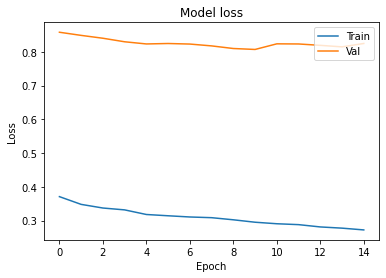

In [21]:
import matplotlib.pyplot as plt
#plotting the loss and val_loss for the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

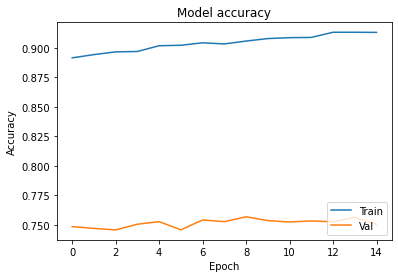

In [22]:
#plotting the accuracy and val_acc for the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

# Performance assessment on Test data

In [23]:
#calculating accuracy
#labels of classes
label = ["airplane","automobile","bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

scores_model = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores_model[0])
print('Test accuracy:', scores_model[1])

10000/10000 [==============================] - 5s 467us/sample - loss: 0.8039 - accuracy: 0.7671
Test loss: 0.8039046216011048
Test accuracy: 0.7671


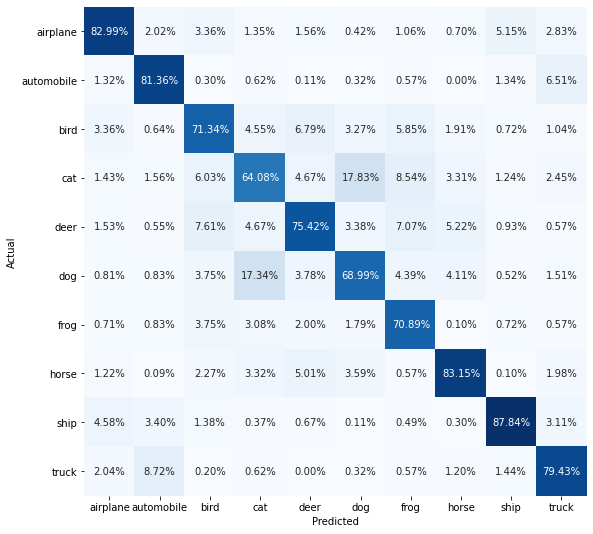

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# making prediction.
prediction = model.predict(X_test)

# Convert predictions classes to  vectors 
Y_pred = np.argmax(prediction, axis=1) 

Y_true = np.argmax(Y_test, axis=1)

# Creating confusion matrix

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm/sum(cm), cbar=False, xticklabels=label, yticklabels=label, fmt='.2%', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

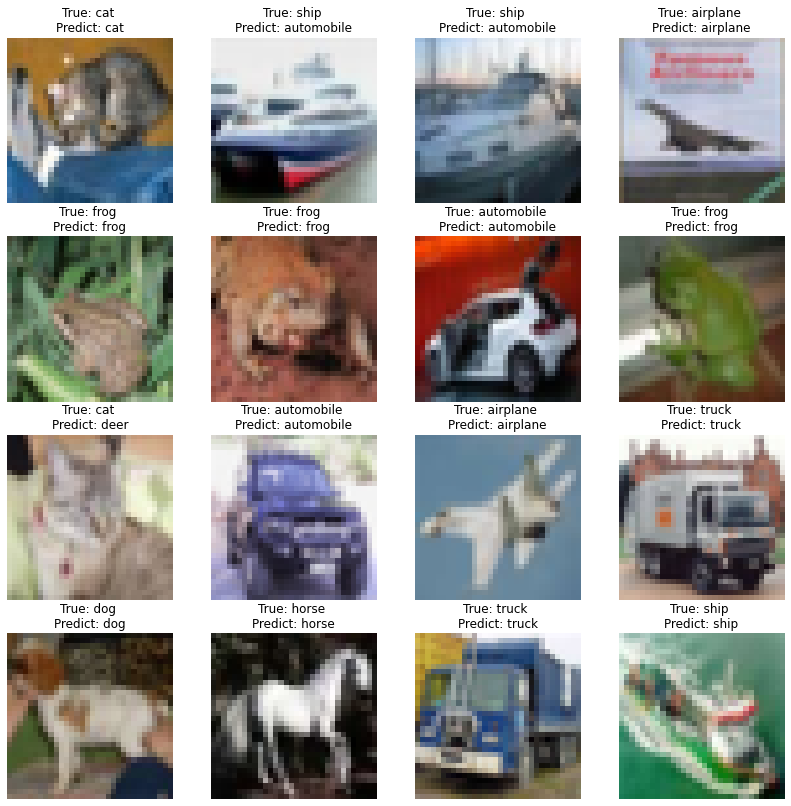

In [26]:
#predicted classes for some test images
Row = 4
Col = 4
fig, axes = plt.subplots(Row, Col, figsize=(14,14))
axes = axes.ravel()

for i in np.arange(0, Row*Col):
    axes[i].imshow(X_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (label[Y_true[i]], label[Y_pred[i]]))
    axes[i].axis('off')